<a href="https://colab.research.google.com/github/Jackson00Han/Time-Series-Training/blob/main/Minutely_multivariate_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal

Thie project aims to predict the future one week Global_active_power values.

##  1. Data Preprocessing


## 1-1. Set Up

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [ ]:
df = pd.read_csv('household_power_consumption.txt', delimiter=';', low_memory=False)
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [ ]:
df.shape

(2075259, 9)

## 1-2. Managing Time Column

In [ ]:
# Manage time column

# I usually set the datetime as the index. You may keep the origional index and datetime column,
# then you just need to use datetime column instead of index later, when selecting data.
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')
df.drop(['Date', 'Time'], axis=1, inplace=True)
df.set_index('datetime', inplace=True)

# Ensure time series is sorted
df.sort_index(inplace=True)

# Calculate time differences
time_diffs = df.index.to_series().diff()

# Identify any irregularities, apart from the first row
irregularities = time_diffs[time_diffs != time_diffs.mode()[0]][1:]

# Display irregularities, if any
if irregularities.empty:
    print("No irregularities found.")
else:
    print("Irregularities found at:")
    print(irregularities)

No irregularities found.


## 1-3. Handling Missing Values

In [ ]:
# Replacing Specific Non-Numeric Values with NaN

# List of non-numeric values to replace
non_numeric_values = ['?', 'N/A', '-', '']

for col in df.columns:
    df[col] = df[col].replace(non_numeric_values, np.nan)
    df[col] = df[col].astype('float64')

In [ ]:
# Check out null value situation
df.isna().sum()

,0
Global_active_power,25979
Global_reactive_power,25979
Voltage,25979
Global_intensity,25979
Sub_metering_1,25979
Sub_metering_2,25979
Sub_metering_3,25979


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


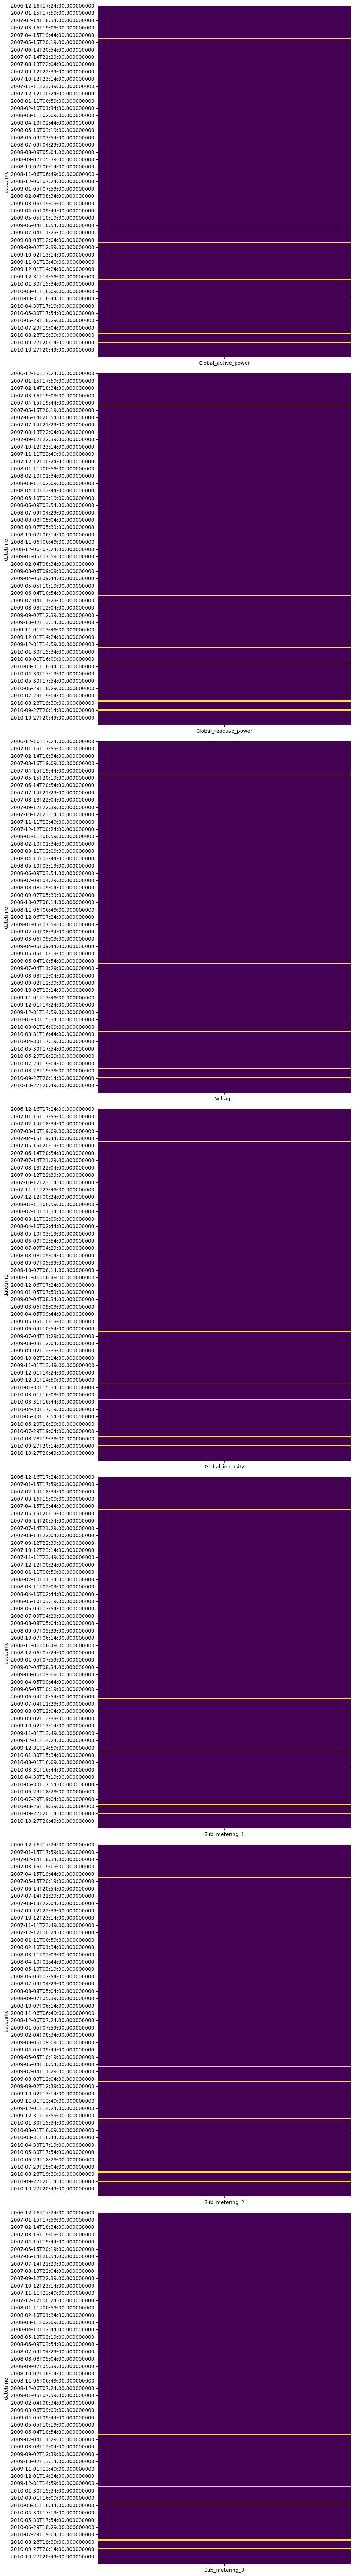

In [ ]:
fig, axs = plt.subplots(7, 1, figsize=(10, 72))

for i, col in enumerate(df.columns[:]):
    sns.heatmap(df[col].isna().to_frame(), cbar=False,cmap='viridis', ax=axs[i])
plt.tight_layout()
plt.show()

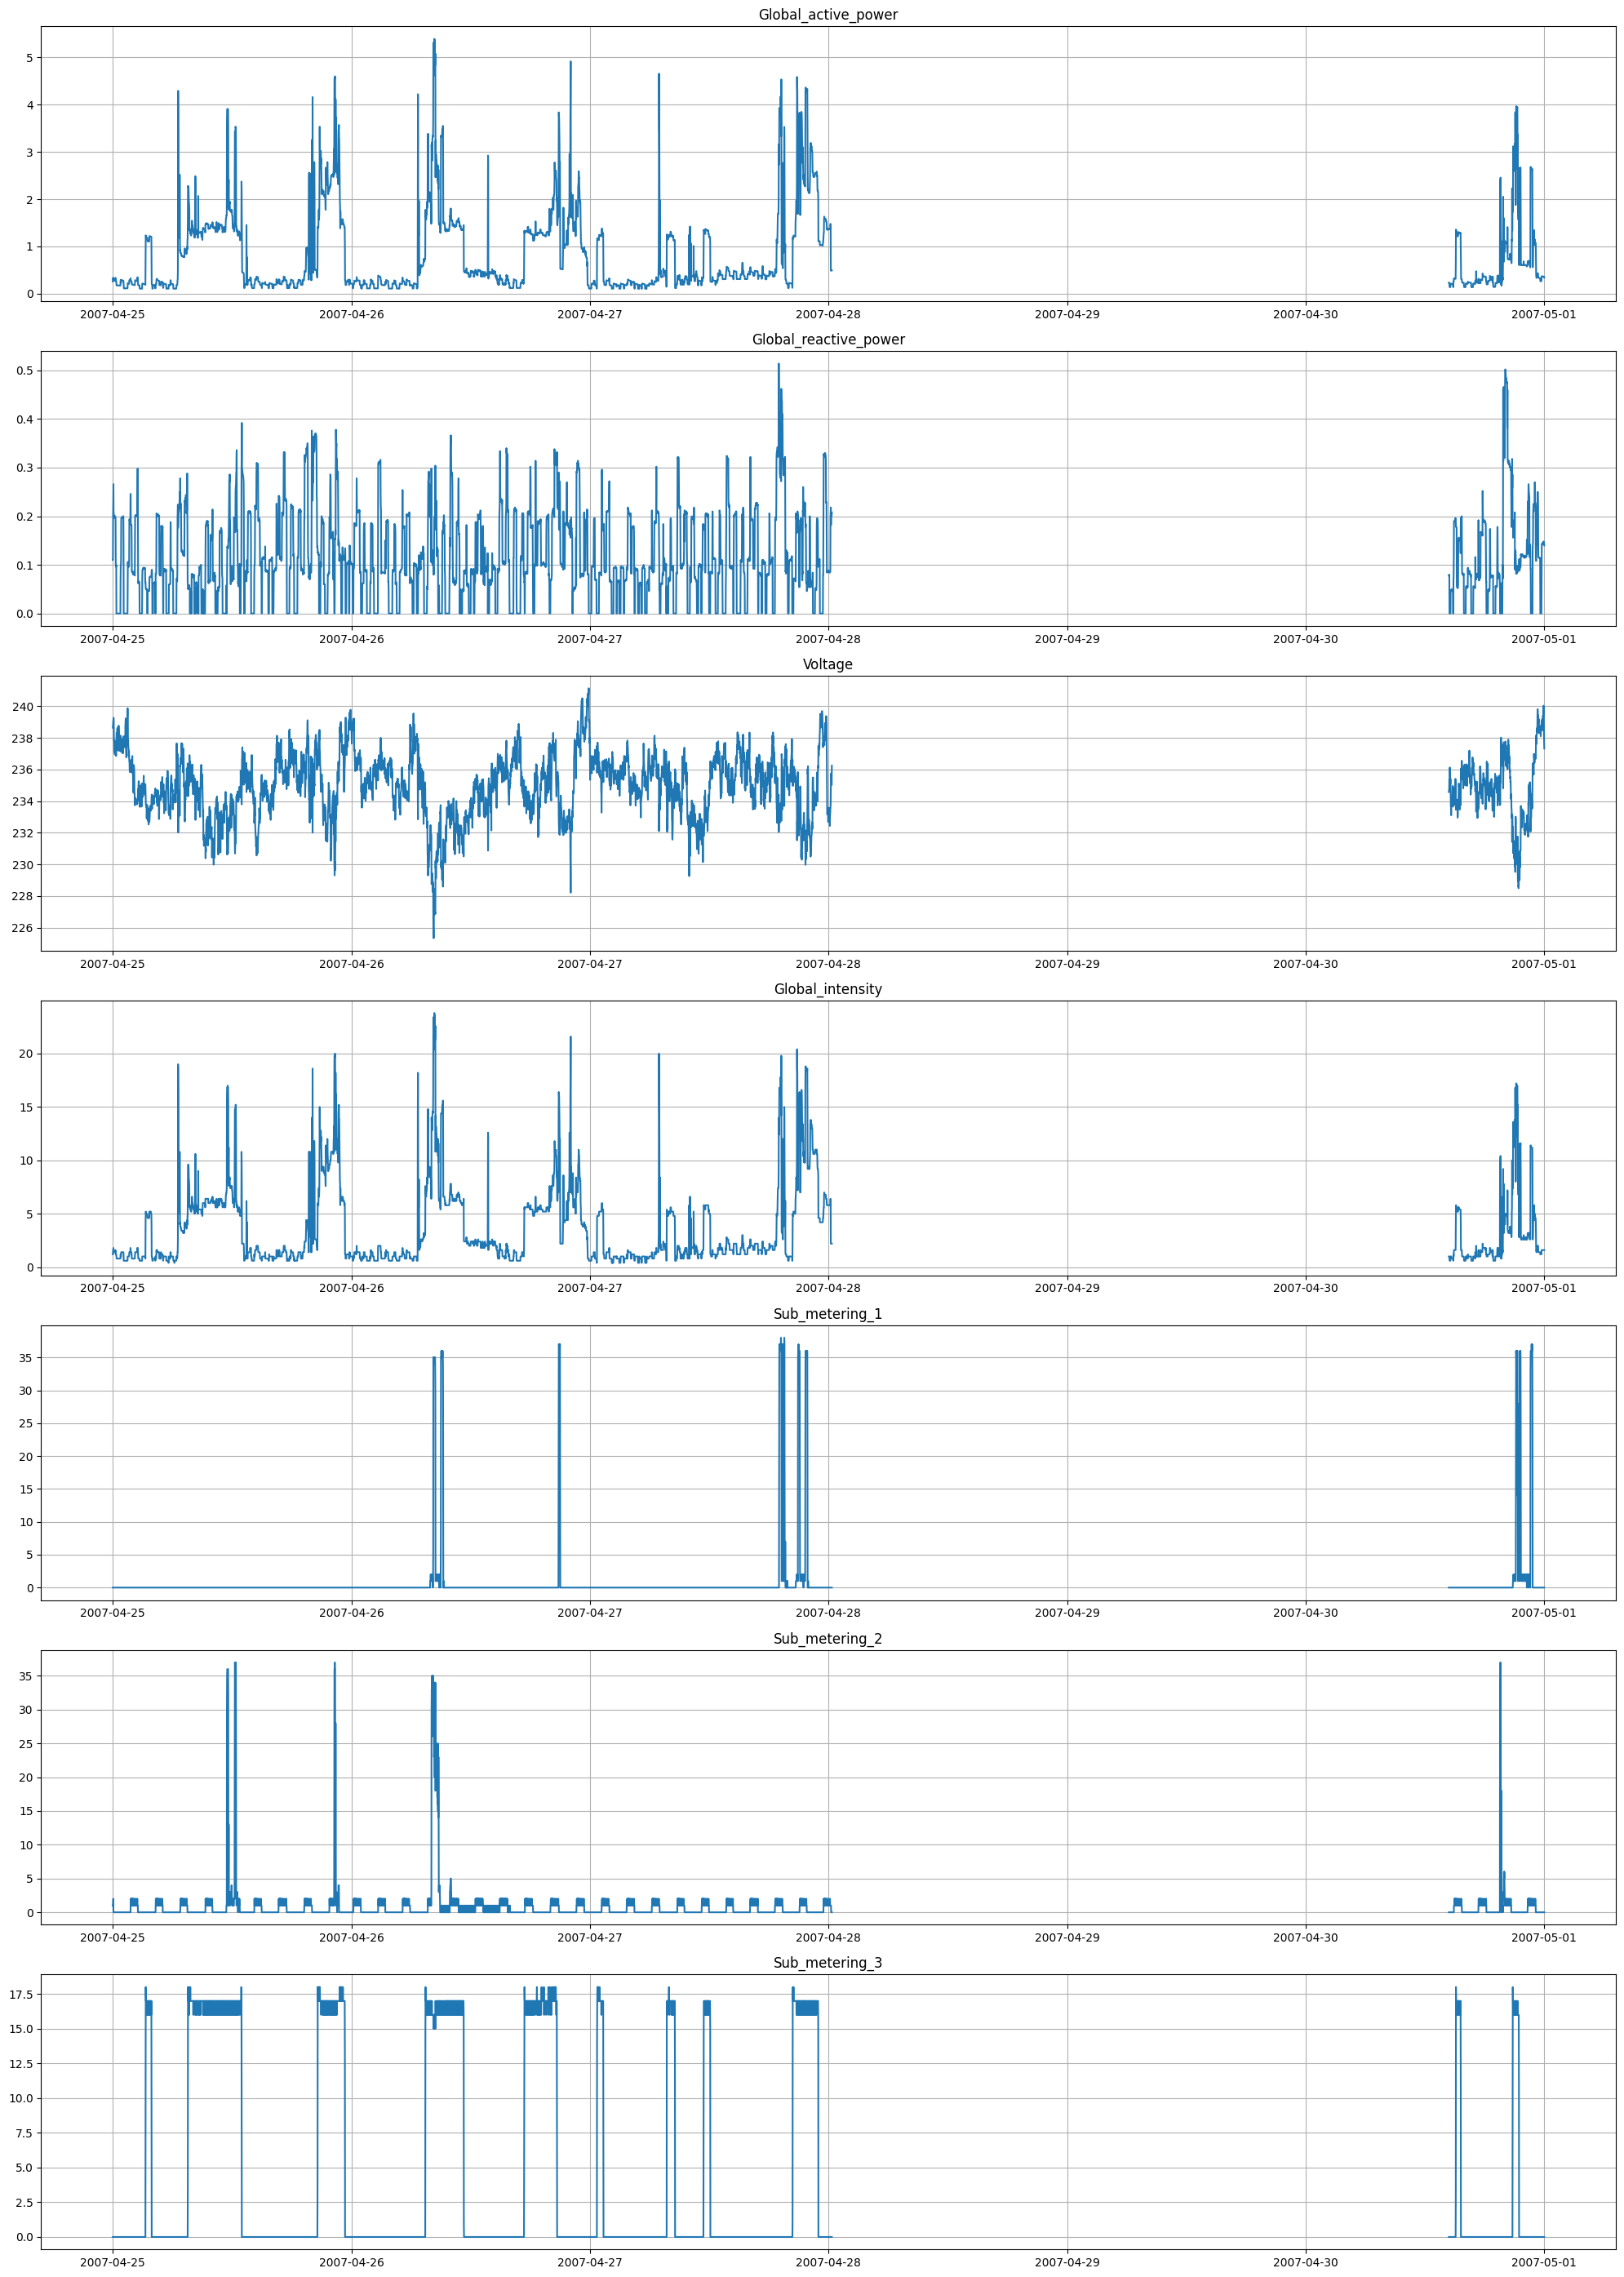

In [ ]:
# Visualizting one period of missing values of different columns

fig, axs = plt.subplots(7, 1, figsize=(20,28))
for i, col in enumerate(df.columns[:]):
    axs[i].plot(df[col].loc['2007-04-25 00:00:00':'2007-05-01 00:00:00'])
    axs[i].set_title(col)
    axs[i].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# The best way to imputing the missing value could be using time seroes models to predict these value, but I will apply a simpler method --
# impute the missing values with rolling means:
window_wize = 60*24*7

for col in df.columns:
    df[col] = df[col].fillna(df[col].rolling(window=window_wize, min_periods=1).mean())

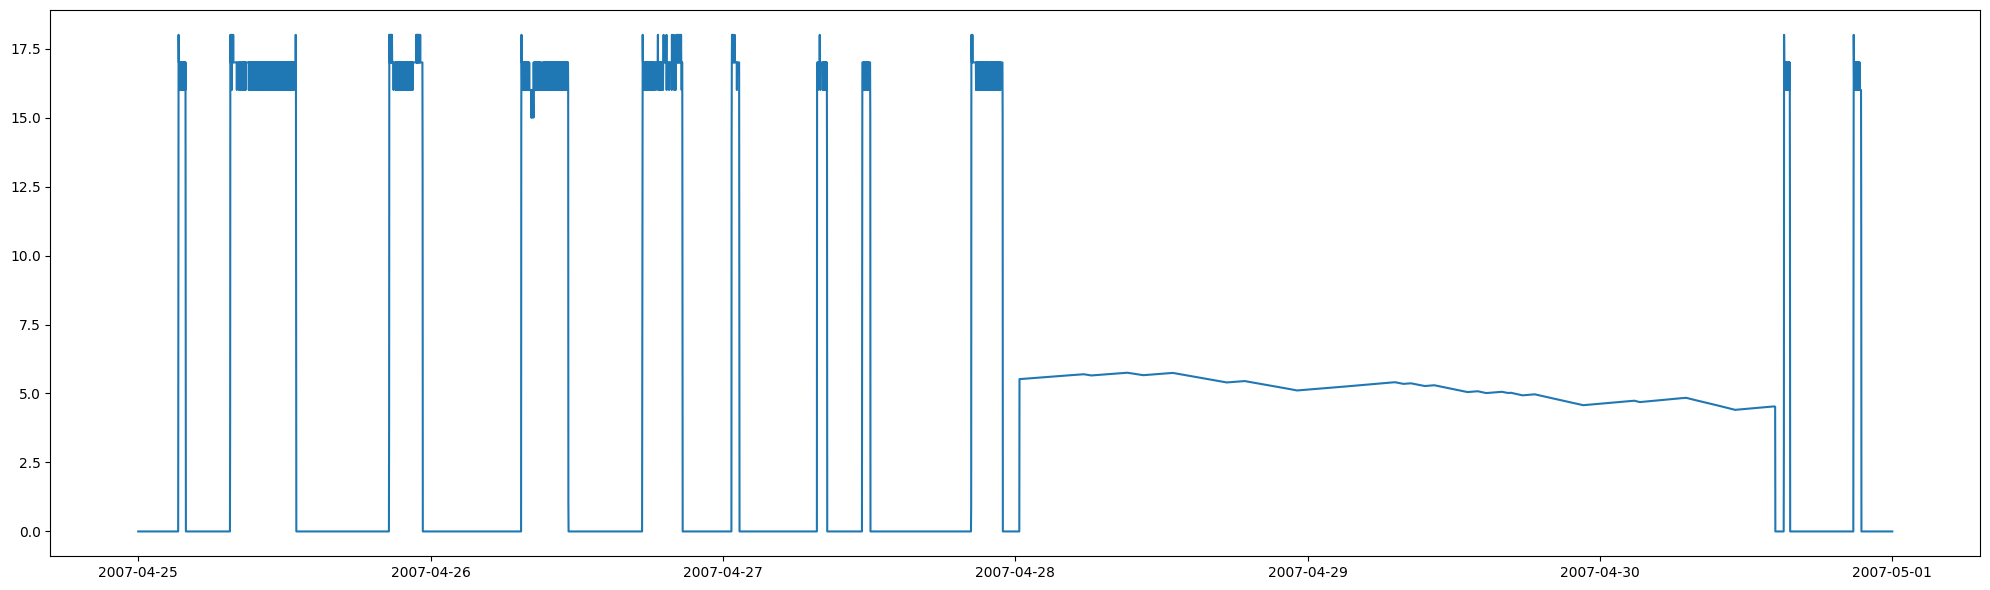

In [ ]:
# Check oen columns again

fig, ax = plt.subplots(figsize=(20,6))

ax.plot(df['Sub_metering_3'].loc['2007-04-25 00:00:00':'2007-05-01 00:00:00'])
plt.tight_layout()
plt.show()

In [ ]:
df.isna().sum()

,0
Global_active_power,0
Global_reactive_power,0
Voltage,0
Global_intensity,0
Sub_metering_1,0
Sub_metering_2,0
Sub_metering_3,0


## 1-4. Formating Data Types

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


## 2. EDA

## 2-1. Visualizing Data

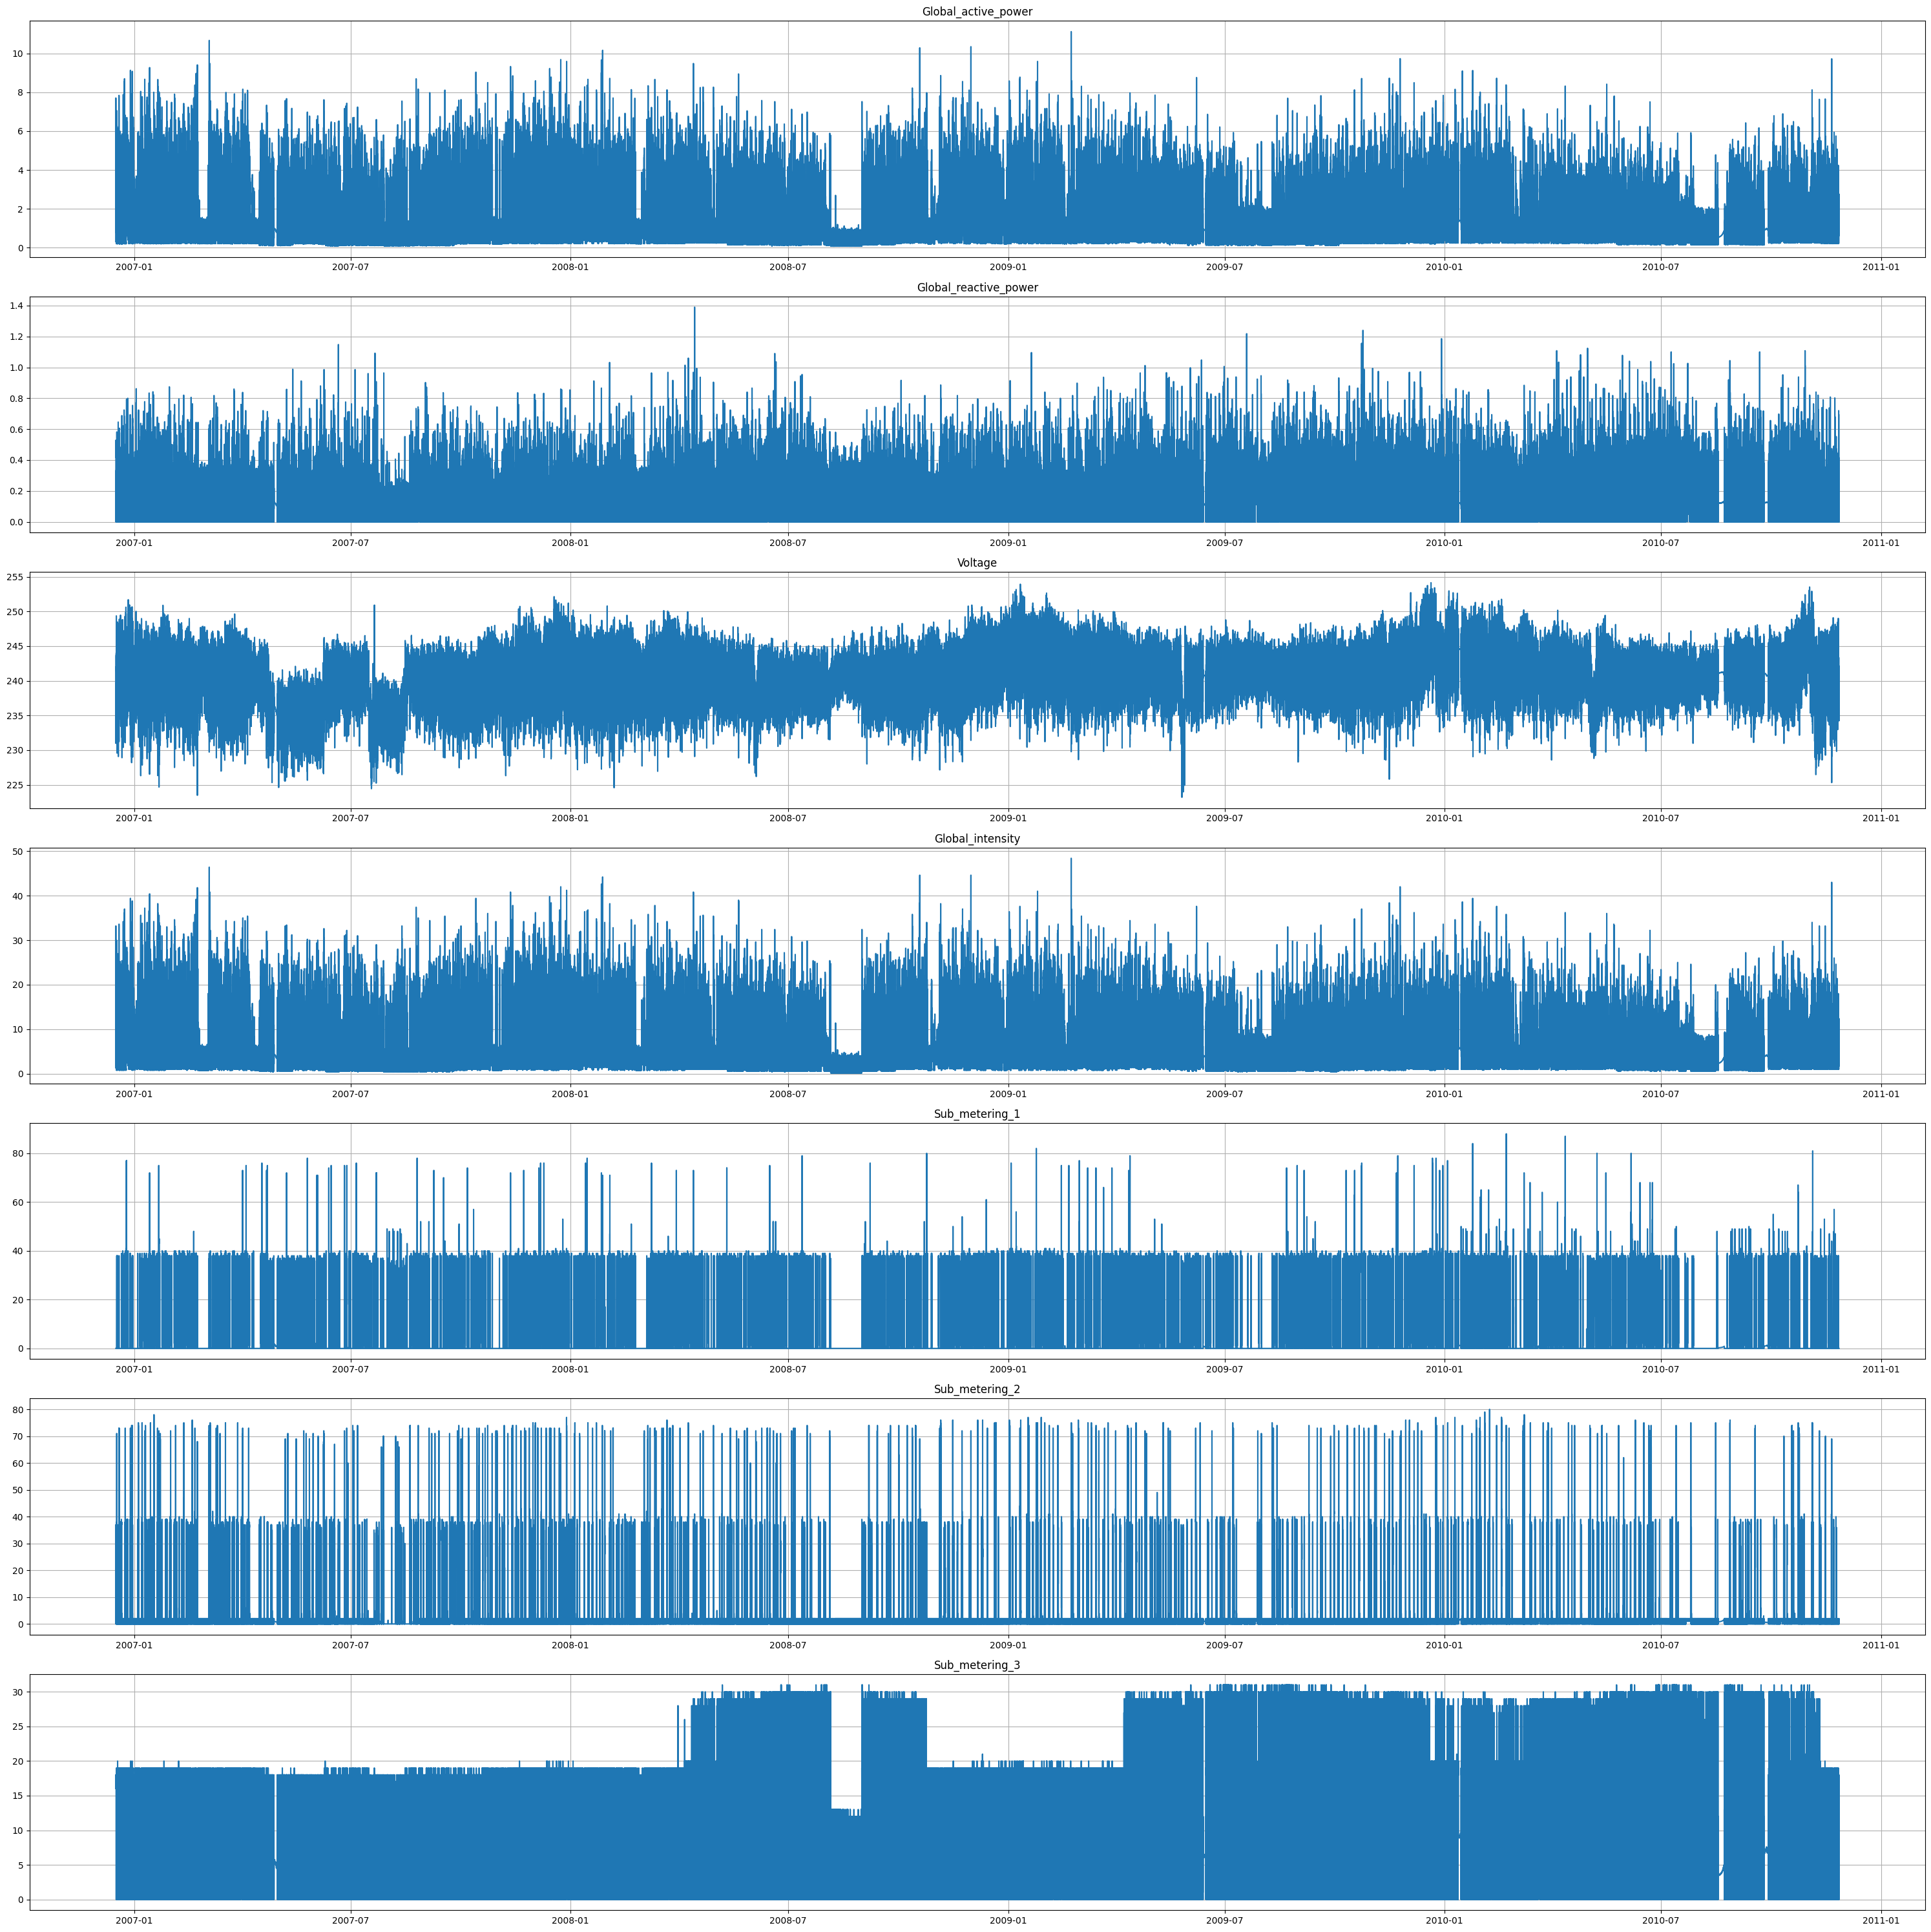

In [ ]:
fig, axs = plt.subplots(7, 1, figsize=(30, 30))

for i, col in enumerate(df.columns[:]):
    axs[i].plot(df[col])
    axs[i].set_title(col)
    axs[i].grid(True)

plt.tight_layout()
plt.show()

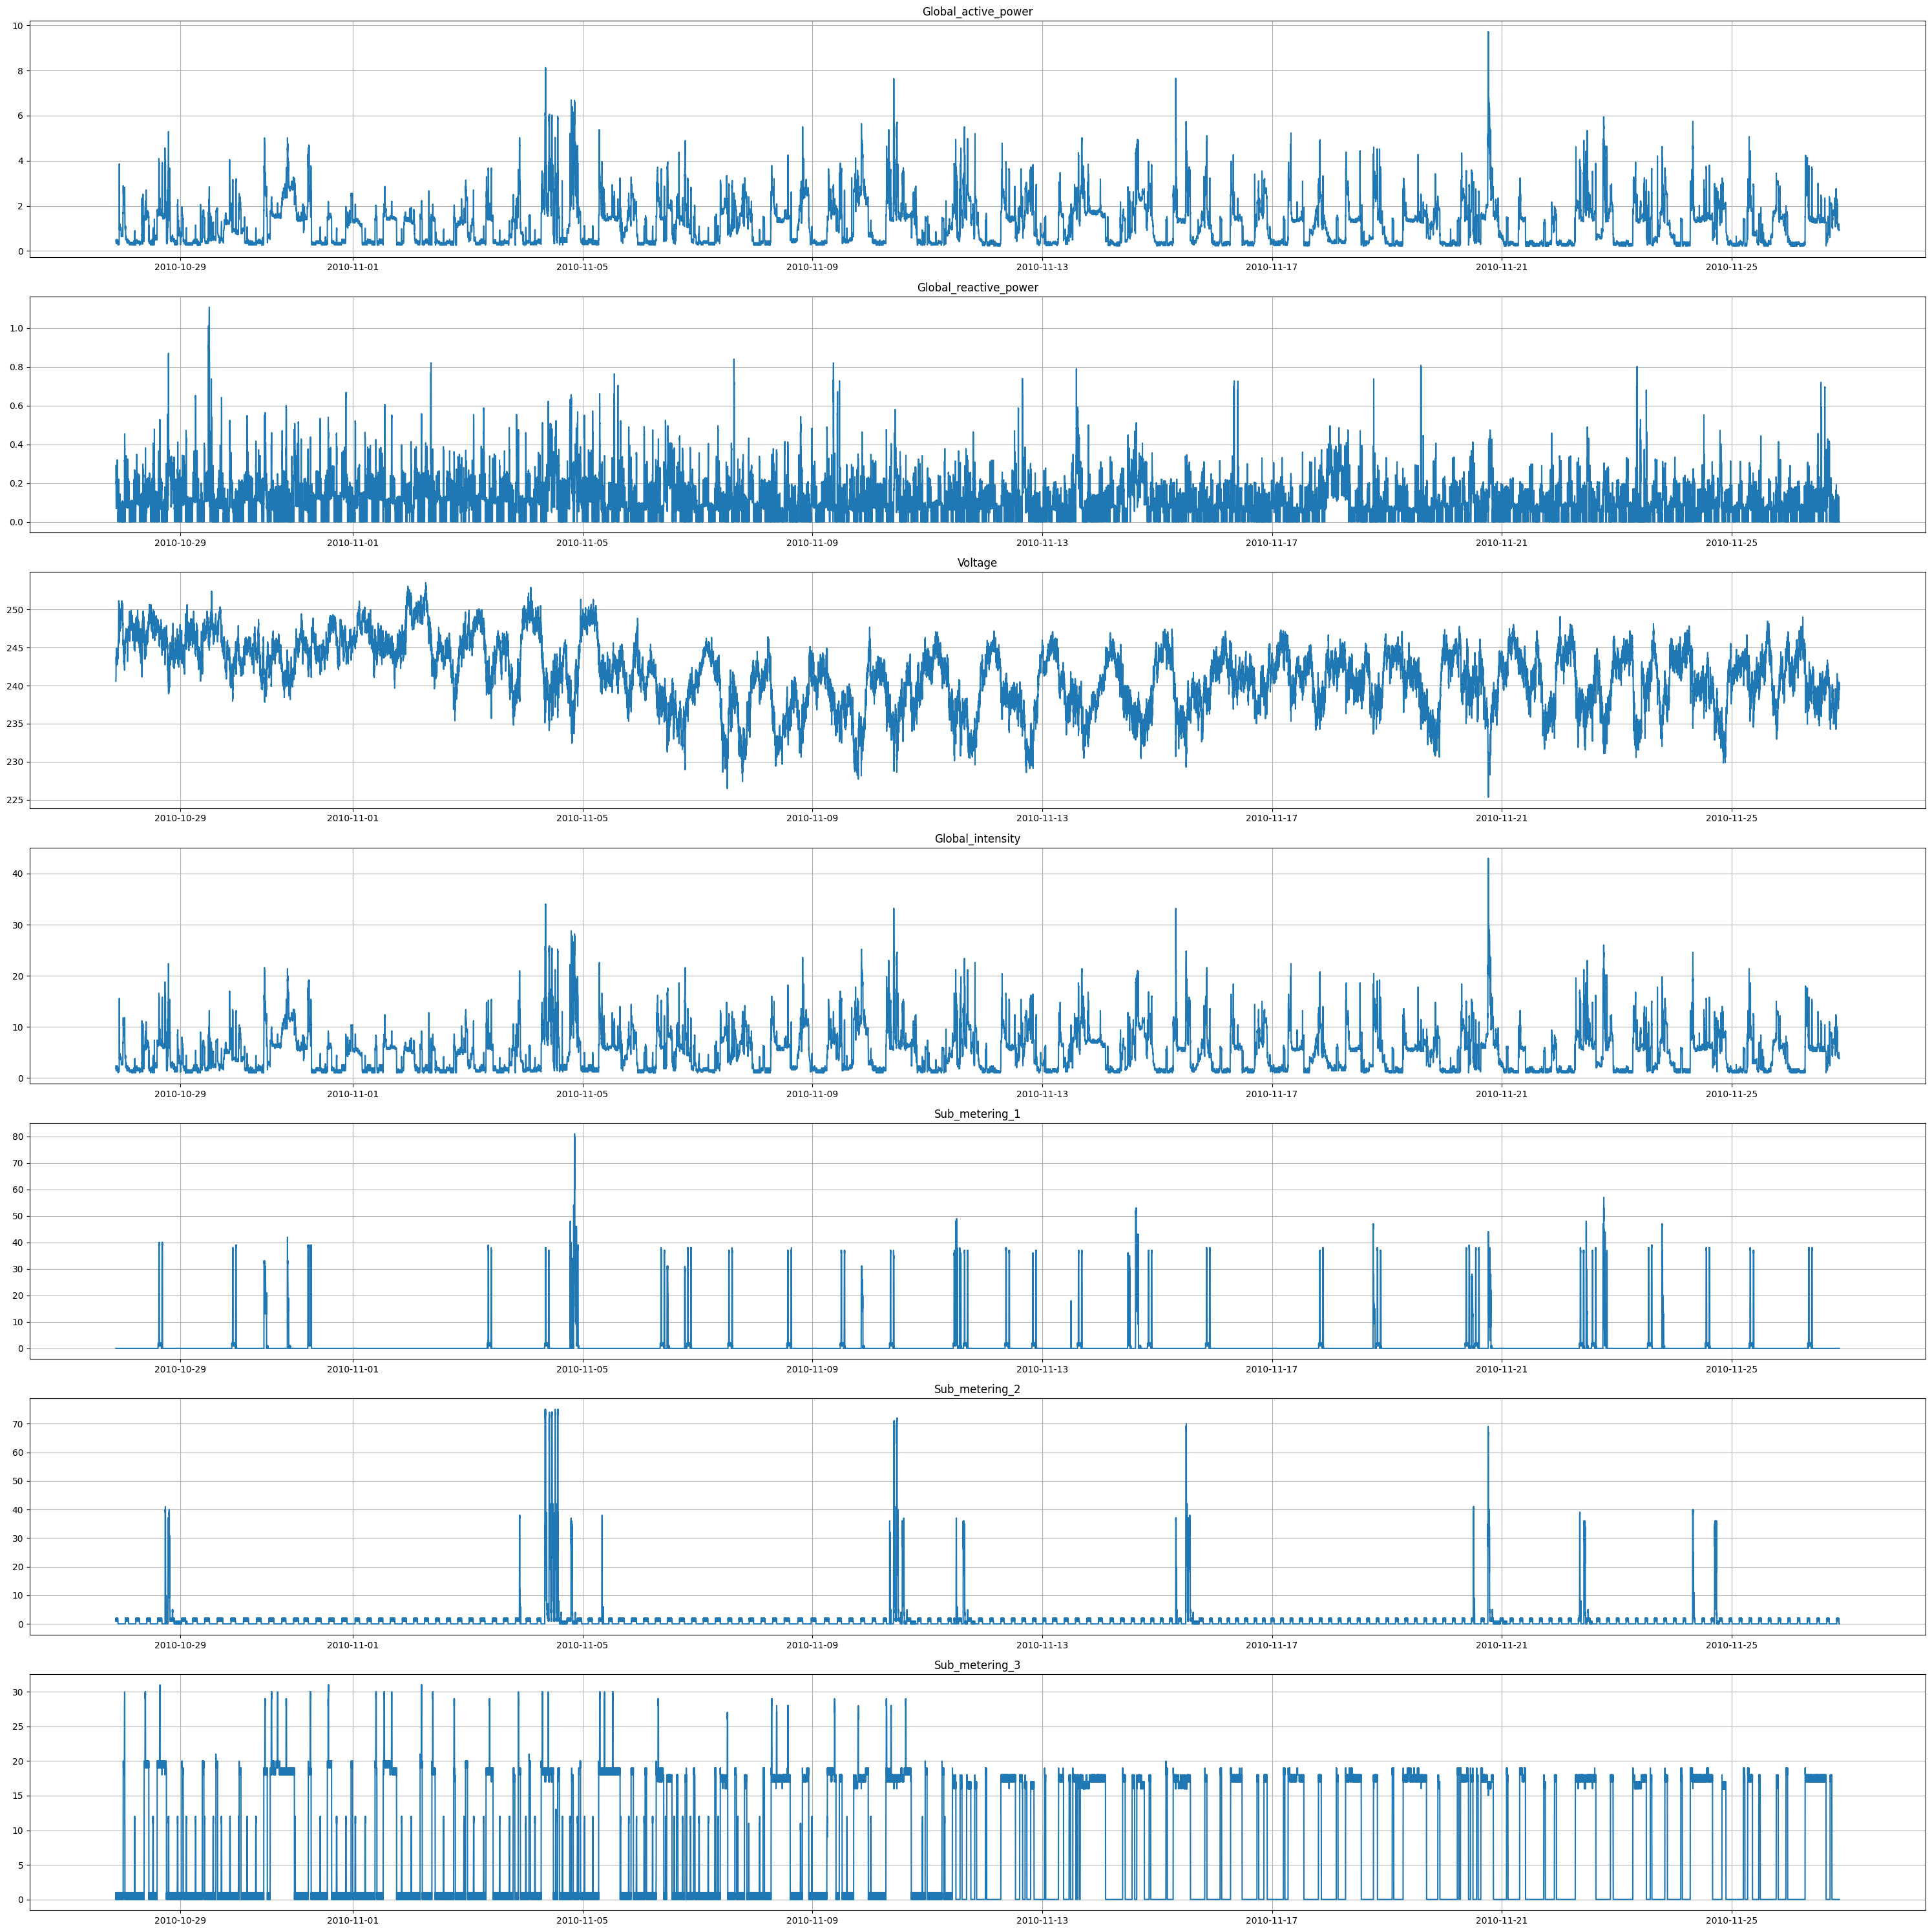

In [ ]:
# Visualize a few data at the end

fig, axs = plt.subplots(7, 1, figsize=(30, 30))

for i, col in enumerate(df.columns[:]):
    axs[i].plot(df[col][-60*24*30:])
    axs[i].set_title(col)
    axs[i].grid(True)

plt.tight_layout()
plt.show()

## 2-2 Statistics of the Dataset

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Global_active_power,2075259.0,1.089427,1.051226,0.076,0.310,0.620,1.520,11.122
Global_reactive_power,2075259.0,0.123711,0.112024,0.000,0.048,0.102,0.192,1.390
Voltage,2075259.0,240.838740,3.230229,223.200,239.000,241.010,242.870,254.150
Global_intensity,2075259.0,4.618755,4.418696,0.200,1.400,2.800,6.400,48.400
Sub_metering_1,2075259.0,1.118185,6.114620,0.000,0.000,0.000,0.000,88.000
Sub_metering_2,2075259.0,1.294622,5.785694,0.000,0.000,0.000,1.000,80.000
Sub_metering_3,2075259.0,6.453180,8.386904,0.000,0.000,1.000,17.000,31.000


In [ ]:
df.corr()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Global_active_power,1.000000,0.246804,-0.397335,0.998888,0.484354,0.434513,0.638750
Global_reactive_power,0.246804,1.000000,-0.111623,0.265908,0.123088,0.139227,0.089532
Voltage,-0.397335,-0.111623,1.000000,-0.409038,-0.195361,-0.166545,-0.266264
Global_intensity,0.998888,0.265908,-0.409038,1.000000,0.489264,0.440298,0.626737
Sub_metering_1,0.484354,0.123088,-0.195361,0.489264,1.000000,0.054753,0.102675
Sub_metering_2,0.434513,0.139227,-0.166545,0.440298,0.054753,1.000000,0.080930
Sub_metering_3,0.638750,0.089532,-0.266264,0.626737,0.102675,0.080930,1.000000


We will fit our model with global_active_power, voltage, sub_meterings in the following.

## 2-3 Data Preparation

### 2-3-1 Features Selection

In [ ]:
# Assuming we only have this period of data
df = df[df.index>='2009-01-01 00:00:00'].copy()

In [ ]:
used_cols = ['Global_active_power', 'Voltage', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
target_col = 'Global_active_power'

for col in used_cols:
    df[f'{col}_roll'] = df[col].rolling(window=5).mean()
df.dropna(inplace=True)

input_cols = ['Global_active_power_roll', 'Voltage_roll', 'Sub_metering_1_roll', 'Sub_metering_2_roll', 'Sub_metering_3_roll']
target_col = 'Global_active_power'

df = df[input_cols + [target_col]].copy()

### 2-3-2 Normalization

In [ ]:
# Example: Applying Min-Max Scaling to your dataset
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

for col in input_cols:
    df[col] = scaler.fit_transform(df[[col]])

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Global_active_power_roll,1000623.0,0.098433,0.097920,0.000,0.022206,0.060367,0.144815,1.000
Voltage_roll,1000623.0,0.582383,0.099634,0.000,0.523933,0.580266,0.641078,1.000
Sub_metering_1_roll,1000623.0,0.012245,0.063708,0.000,0.000000,0.000000,0.000000,1.000
Sub_metering_2_roll,1000623.0,0.014112,0.062341,0.000,0.000000,0.000000,0.015152,1.000
Sub_metering_3_roll,1000623.0,0.225858,0.270809,0.000,0.019355,0.025806,0.580645,1.000
Global_active_power,1000623.0,1.067072,0.964513,0.122,0.330000,0.684000,1.502000,11.122


### 2-3-3 Train Test Split

In [ ]:
split_time1 = '2009-01-01 00:00:00'
split_time2 = '2010-01-01 00:00:00'
split_time3 = '2010-01-01 00:01:00'
split_time4 = '2010-07-01 00:00:00'
train = df.loc[split_time1:split_time2]
val = df.loc[split_time3:split_time4]

## 2-3-4 Generate Dataset for Models



```
window_size = 3

dataset = tf.data.Dataset.from_tensor_slices(train)
dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)

dataset = dataset.flat_map(lambda window: window.batch(window_size+1))

for window in dataset.take(1):
  print(window.numpy())
  print(f'shape: {window.numpy().shape}')

[[  0.482  247.138    0.       0.       0.       0.484 ]
 [  0.4824 247.212    0.       0.       0.       0.484 ]
 [  0.4824 247.364    0.       0.       0.       0.482 ]
 [  0.4828 247.564    0.       0.       0.       0.482 ]]
shape: (4, 6)

for window in dataset.take(1):
  print(window[:-1,:-1], window[-1][-1])

tf.Tensor(
[[  0.482  247.138    0.       0.       0.    ]
 [  0.4824 247.212    0.       0.       0.    ]
 [  0.4824 247.364    0.       0.       0.    ]], shape=(3, 5), dtype=float64) tf.Tensor(0.482, shape=(), dtype=float64)

# group into features and lables
dataset = dataset.map(lambda window: (window[:-1,:-1], window[-1][-1]))

for x, y in dataset.take(2):
  print('x = ', x.numpy())
  print('y = ', y.numpy())
  print()

x =  [[  0.482  247.138    0.       0.       0.    ]
 [  0.4824 247.212    0.       0.       0.    ]
 [  0.4824 247.364    0.       0.       0.    ]]
y =  0.482

x =  [[  0.4824 247.212    0.       0.       0.    ]
 [  0.4824 247.364    0.       0.       0.    ]
 [  0.4828 247.564    0.       0.       0.    ]]
y =  0.482
```



#### 2-3-4-1 Single Step

In [ ]:
# Parameters
window_size = 5
batch_size = 32
shuffle_buffer_size = 60*24*30 # this value depends on the size of the data, around the len(data) for small data and smaller len(data) for big data

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer, feature_columns, label_columns, column_names):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series, not necessarily univariate
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method
      feature_columns (list of str or int) - the names or indices of the columns to be used as features
      label_columns (str or int) - the name or index of the column to be used as the label
      column_names (list of str, optional) - the names of the columns in the series

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # If column names are provided, map feature_columns and label_columns from names to indices
    if column_names is not None:
        feature_columns = [column_names.index(col) if isinstance(col, str) else col for col in feature_columns]
        label_columns = [column_names.index(col) if isinstance(col, str) else col for col in label_columns]
    else:
        # If no column names are provided, assume feature_columns and label_columns are indices
        raise ValueError(f"column_names are missing")

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with specified features and label
    dataset = dataset.map(lambda window: (tf.gather(window[:-1], feature_columns, axis=-1),
                                          tf.gather(window[-1], label_columns, axis=-1)))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset


In [ ]:
column_names = df.columns.to_list()

feature_columns = ['Global_active_power_roll', 'Voltage_roll', 'Sub_metering_1_roll', 'Sub_metering_2_roll', 'Sub_metering_3_roll']
label_columns = ['Global_active_power']

train_set = windowed_dataset(train, window_size, batch_size, shuffle_buffer_size, feature_columns, label_columns, column_names)

```
for windows in train_set.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  print(f'shape of first element: {windows[0].shape}')
  print(f'shape of second element: {windows[1].shape}')

data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (32, 60, 5)
shape of second element: (32, 1)

```

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Flatten


# Build the RNN Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=8, kernel_size=2, strides=1, padding='causal', activation='relu',
                          input_shape=[window_size, len(feature_columns)]),
    tf.keras.layers.LSTM(5, return_sequences=False),
    tf.keras.layers.Dense(1),
])
# Compile the model
model.compile(loss="mse", optimizer="adam")

# Train the model
model.fit(train_set, epochs=3)


Epoch 1/3
16425/16425 ━━━━━━━━━━━━━━━━━━━━ 143s 8ms/step - loss: 0.3273
Epoch 2/3


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


16425/16425 ━━━━━━━━━━━━━━━━━━━━ 147s 9ms/step - loss: 0.0944
Epoch 3/3
16425/16425 ━━━━━━━━━━━━━━━━━━━━ 145s 8ms/step - loss: 0.0876


In [ ]:
def model_forecast(model, test_series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size
    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(test_series.iloc[:,:-1]) #separate out the label

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

In [ ]:
forecast = model_forecast(model, val, window_size, batch_size)

8144/8144 ━━━━━━━━━━━━━━━━━━━━ 106s 13ms/step


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [ ]:
actual = val.iloc[window_size:,-1].to_list()

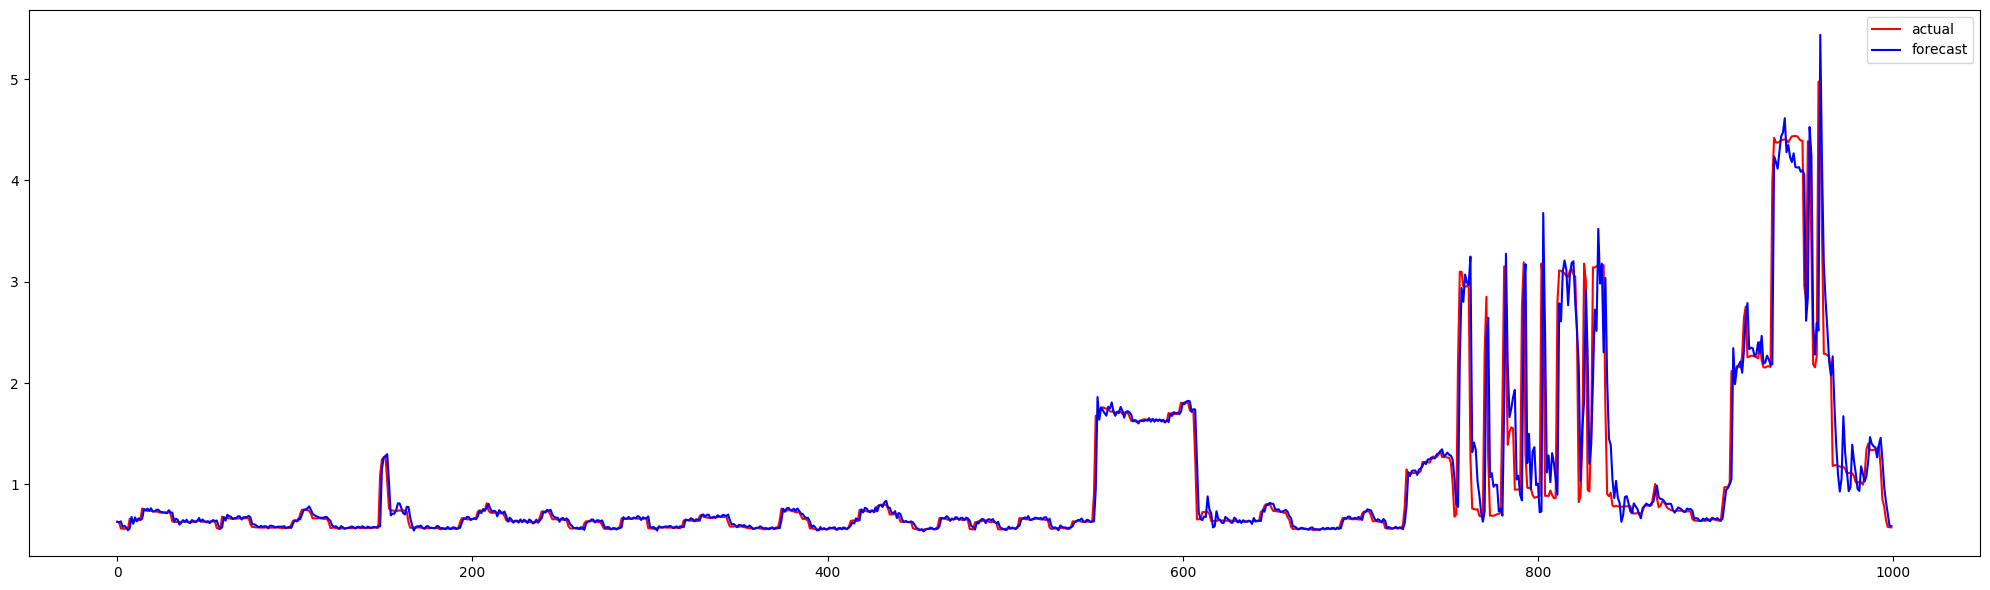

In [ ]:
fig, ax = plt.subplots(figsize=(20,6))
ax.plot(actual[:1000], c='red', label='actual')
ax.plot(forecast[:1000], c= 'blue', label='forecast')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

mse = mean_squared_error(actual, forecast[:-1])
mae = mean_absolute_error(actual, forecast[:-1])

print(f'mse: {mse}')
print(f'mae: {mae}')

mse: 0.05341769558841868
mae: 0.09450932313203626
